In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import email
import string
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
import wordcloud
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(49)

In [2]:
dir_1="C:\\Users\\HP\\Desktop\\Data\\"
easy_ham_path= dir_1 + "easy_ham\\"
easy_ham_path_2=dir_1 + "easy_ham_2\\"
hard_ham_path=dir_1 + "hard_ham\\"
spam_path_1=dir_1 + "spam\\"
spam_path_2=dir_1 + "spam_2\\"

In [3]:
def fetch_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

In [4]:
easy_ham=fetch_data(easy_ham_path)
easy_ham_2=fetch_data(easy_ham_path_2)
hard_ham=fetch_data(hard_ham_path)
ham=easy_ham+easy_ham_2+hard_ham
spam_1=fetch_data(spam_path_1)
spam_2=fetch_data(spam_path_2)
spam=spam_1+spam_2

In [5]:
np.random.shuffle(ham)
np.random.shuffle(spam)

In [27]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
class clean_email_text(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        text_list = []
        for mail in X:
            b = email.message_from_string(mail)
            body = ""
            if b.is_multipart():
                for part in b.walk():
                    content_type = part.get_content_type()
                    content_disposition = str(part.get('Content-Disposition'))
                    if content_type == 'text/plain' and 'attachment' not in content_disposition:
                        body = part.get_payload(decode=True)
                        break
            else:
                body = b.get_payload(decode=True)
            soup = BeautifulSoup(body, "html.parser")
            text = soup.get_text().lower()
            text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text, flags=re.MULTILINE)     
            text = text.translate(str.maketrans('', '', string.punctuation))
            text = ''.join([i for i in text if not i.isdigit()])
            stop_words = stopwords.words('english')
            words_list = [w for w in text.split() if w not in stop_words]
            words_list = [lemmatizer.lemmatize(w) for w in words_list] 
            text_list.append(' '.join(words_list))
                    
        return text_list

In [28]:
email_to_text = clean_email_text()

In [29]:
ham_text=email_to_text.transform(ham)
spam_text=email_to_text.transform(spam)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHA

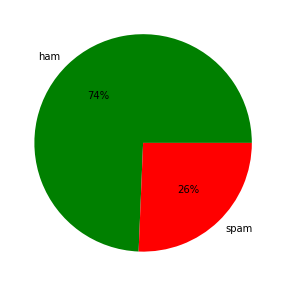

In [10]:
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['ham', 'spam']
colors = ['green', 'red']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

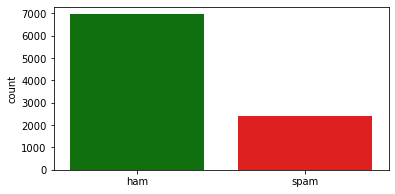

In [11]:
plt.figure(figsize=(6,3))
sns.countplot(x = ['ham']*len(ham) + ['spam']*len(spam), palette=colors)
plt.show()

In [12]:
y = len(ham_text)*[0] + len(spam_text)*[1]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ham_text+spam_text, y,
                                                    stratify=y, 
                                                    test_size=0.2)

In [14]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(X_train)

CountVectorizer(stop_words='english')

In [15]:
X_train = vectorizer.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)

In [16]:
X_test = vectorizer.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [19]:
predictions = logmodel.predict(X_test)

In [20]:
print("accuracy score = {}%".format(round(accuracy_score(y_test, predictions)*100, 2)))
print("f1_Score = {}".format(round(f1_score(y_test, predictions)*100, 2)))
print("recall_score = {}".format(round(recall_score(y_test, predictions)*100, 2)))
print("precision_Score = {}".format(round(precision_score(y_test, predictions)*100, 2)))

accuracy score = 98.72%
f1_Score = 97.51
recall_score = 97.71
precision_Score = 97.3


In [21]:
confusion_matrix(y_test,predictions)

array([[1378,   13],
       [  11,  469]], dtype=int64)

In [23]:
print("Mean squared error using scaled data: %.2f\n"
      % mean_squared_error(y_test, predictions))

Mean squared error using scaled data: 0.01



In [30]:
pipeline = Pipeline(steps=[
    ('text', clean_email_text()),
    ('vector', vectorizer),
    ('model', logmodel)])

In [31]:
x_1 = np.array(len(ham)*[0]+len(spam)*[1]).reshape(len(ham+spam), 1)

In [32]:
pipeline.fit(ham+spam, x_1)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHA

Pipeline(steps=[('text', clean_email_text()),
                ('vector', CountVectorizer(stop_words='english')),
                ('model', LogisticRegression())])